# **LSTM Prediction model**
This notebook will be dividided by sections as follows:\
-Data load\
-Data Preparation\
-Build LSTM\
-Fit LSTM\
-Forecast Predictions\

### **Data Loading**

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random


confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

### **Data Preparation**


In [4]:
class Data():
    def __init__(self,country):
        self.country = country
        self.confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        self.deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        self.recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
        self.PreparaData()

    def PreparaData(self):
        confirmedPortugal = self.confirmed[ self.confirmed['Country/Region'] != self.country].index
        self.confirmed.drop(confirmedPortugal , inplace=True)
        deathsPortugal = self.deaths[ self.deaths['Country/Region'] != self.country].index
        self.deaths.drop(deathsPortugal , inplace=True)
        recoveredPortugal = self.recovered[ self.recovered['Country/Region'] != self.country].index
        self.recovered.drop(recoveredPortugal , inplace=True)
        self.confirmed = self.confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.deaths = self.deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        self.recovered = self.recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in self.confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(self.confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in self.deaths.columns:
            total_Deaths.append(self.deaths[cols].sum())
        for cols in self.recovered.columns:
            total_Recovered.append(self.recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv',index=False)

In [95]:
class LSTM():
    def __init__(self):
        self.df = pd.read_csv('Dados/new_dataset.csv')
        self.NormalizeData()
        self.timesteps = 15
        self.nr_parametos=1
        self.PrepareData(self.timesteps)
        self.Build(self.timesteps,self.nr_parametos)
        self.Fit()
    def NormalizeData(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(self.df)
        #print(self.normalized)
        
    def Denormalize(self,dfNormalized):
        pass
    
    
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,0:1])
                self.Y.append(self.normalized[input_index:label_index,0:1])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        #print(self.X)
        X = self.X
        #print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.LSTM(32, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.LSTM(64, return_sequences=True))
        self.model.add(keras.layers.LSTM(128, return_sequences=False))
        self.model.add(keras.layers.Dropout(0.2))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dense(1, activation="linear"))
        
    def Build1(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.LSTM(16, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.LSTM(32, return_sequences=True))
        self.model.add(keras.layers.LSTM(64, return_sequences=False))
        self.model.add(keras.layers.Dense(32, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dense(1, activation="linear"))
                       
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,shuffle=False,verbose=False)
    def Predict(self,data):
        result = self.model.predict(data,verbose=False)
        return result
        
    def forecast(self):
        timesteps= self.timesteps
        multisteps=50
        data_norm=pd.DataFrame(self.normalized)
        input_seq=data_norm[-timesteps:].values
        inp=input_seq[:,0]
        
        
        predictions=list()
        
        inp = np.array(inp).astype('float32')
        #print(inp)
        for step in range(1, multisteps+1):
            
            inp=inp.reshape(1,timesteps,1)
            taxa_Erro = random.uniform(-0.005,0.005 )
            yhat=self.Predict(inp) + taxa_Erro
            Denormalized = np.ndarray((1,4))
            Denormalized[0][0] = yhat
            Denormalized[0][1] = -1
            Denormalized[0][2] = -1
            Denormalized[0][3] = -1
            #print(self.scaler)
            #print(self.normalized)
            value = self.scaler.inverse_transform(Denormalized)
            #print(value)
            predictions.append(value[0][0])
            #predictions.append(yhat[0][0])
            inp=np.append(inp[0],yhat)
            inp=inp[-timesteps:]
            #print(inp)
            
        self.PredictionGraph(predictions)
    def PredictionGraph(self,prediction):
        fig, ax = plt.subplots(figsize=(20, 10))
        fig.suptitle('Previsao Casos ', fontsize=30, fontweight='bold')
        plt.xlabel('Dia', fontsize=20)
        plt.ylabel('Previsão', fontsize=20)
        ax.plot(np.arange(len(self.df)),(self.df['Total_Cases']), label='Days Gone with real data')
        ax.plot(np.arange(len(self.df),len(self.df) + len(prediction)),(prediction), label='10 days LSTM prediction')
        ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,fontsize='15')
        #plt.xticks(self.df['Days_Gone'])
        ax.grid()
        #fig.savefig('static/lstm.png')

In [96]:
country = "US"
data = Data(country)


In [97]:
data.new_dataset

,Total_Cases,Total_Recovered,Total_Deaths,Days_Gone
0,1,0,0,22
1,1,0,0,23
2,2,0,0,24
3,2,0,0,25
4,5,0,0,26
...,...,...,...,...
95,965785,106988,54881,117
96,988197,111424,56259,118
97,1012582,115936,58355,119
98,1039909,120720,60967,120


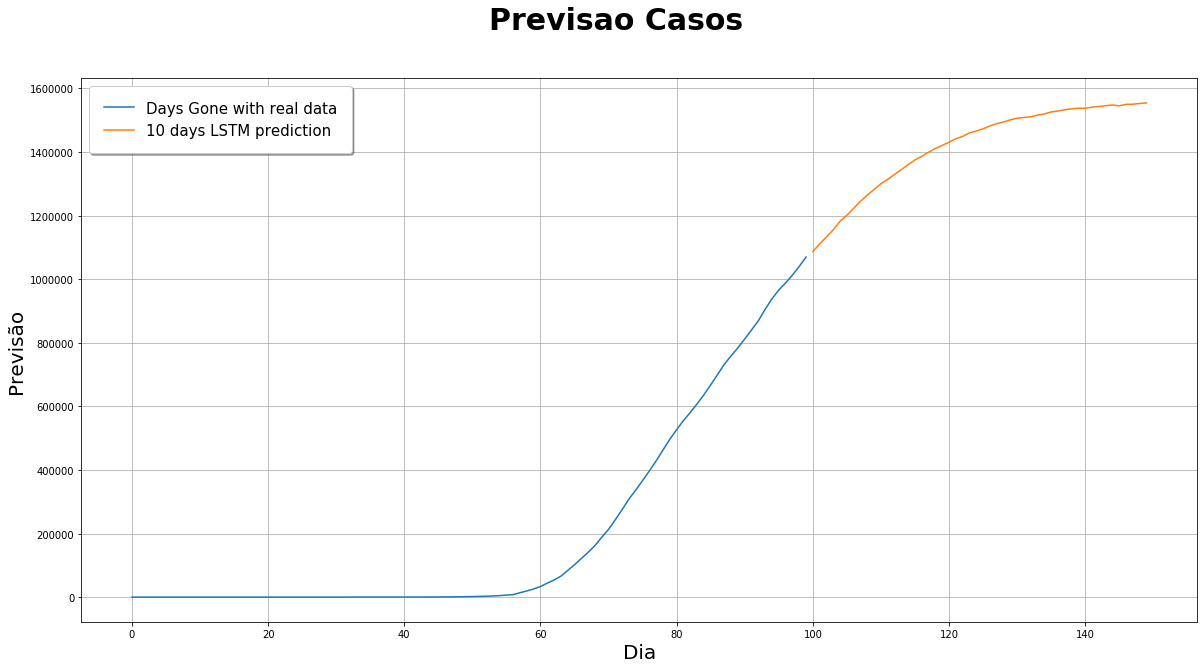

In [99]:
lstm = LSTM()
lstm.forecast()

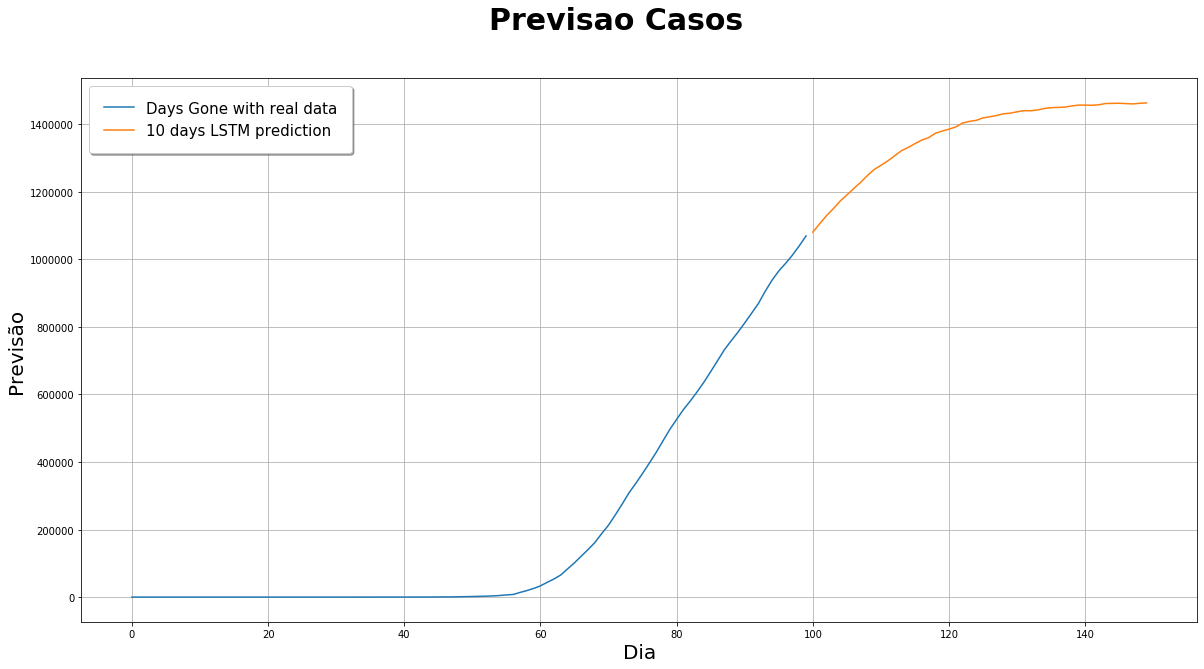

In [94]:
lstm = LSTM()
lstm.forecast()